# Project 3: Classification
Daniel Arthur

Introduction and Buisness Understanding/

Climate change has increased water insecurity. This problem has an outsized effect in Tanzania. I will create a model to predict the functionality of wells in Tanzania. This infomation can then be used to guide action to mitigate problems and improve water access. The stakeholders is the Wells of Life Charity. They are located north of Tanzania in Uganda. Their close proximity is ideal, since it reduces cost of resource distribution. 

Importing the necessary libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.ensemble import ExtraTreesClassifier, VotingClassifier, StackingRegressor

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score
# plot_confusion_matrix is a handy visual tool, added in the latest version of scikit-learn
# if you are running an older version, comment out this line and just use confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

Functions

In [2]:
def Evaluate(true, preds, model_name):
    acc = accuracy_score(true, preds)
    f1 = f1_score(true, preds, average = 'macro')
    prec = precision_score(true, preds, average = 'macro')
    rec = recall_score(true, preds, average = 'macro')
    
    print("Model: {}".format(model_name))
    print("Accuracy: {}".format(acc))
    print("F1-Score: {}".format(f1))
    print('Precision: {}'.format(prec))
    print('Recall: {}'.format(rec))

In [3]:
def PrintEvaluation(y_train, y_test, X_train, X_test, train_preds, test_preds, model):
    print("Training Metrics")
    Evaluate(y_train, train_preds, model)
    print("")
    
    print('Training Cross Val Score')
    print(cross_val_score(model, X_train, y_train, cv=5))
    print("")
    
    print("Testing Metrics")
    Evaluate(y_test, test_preds, model)
    print("")
    
    print('Testing Cross Val Score')
    print(cross_val_score(model, X_test, y_test, cv=5))

In [4]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [5]:
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

In [6]:
def find_best_k(X_train, y_train, X_test, y_test, min_k=1, max_k=25):
    best_k = 0
    best_score = 0.0
    for k in range(min_k, max_k+1, 2):
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train)
        preds = knn.predict(X_test)
        f1 = f1_score(y_test, preds, average = 'micro')
        if f1 > best_score:
            best_k = k
            best_score = f1
    
    print("Best Value for k: {}".format(best_k))
    print("F1-Score: {}".format(best_score))

Importing the data that will be used.


The Data contains records of over 50,000 wells in Tanzania. 

Columns Info

amount_tsh - Total static head (amount water available to waterpoint)\
date_recorded - The date the row was entered\
funder - Who funded the well\
gps_height - Altitude of the well\
installer - Organization that installed the well\
longitude - GPS coordinate\
latitude - GPS coordinate\
wpt_name - Name of the waterpoint if there is one\
num_private -\
basin - Geographic water basin\
subvillage - Geographic location\
region - Geographic location\
region_code - Geographic location (coded)\
district_code - Geographic location (coded)\
lga - Geographic location\
ward - Geographic location\
population - Population around the well\
public_meeting - True/False\
recorded_by - Group entering this row of data\
scheme_management - Who operates the waterpoint\
scheme_name - Who operates the waterpoint\
permit - If the waterpoint is permitted\
construction_year - Year the waterpoint was constructed\
extraction_type - The kind of extraction the waterpoint uses\
extraction_type_group - The kind of extraction the waterpoint uses\
extraction_type_class - The kind of extraction the waterpoint uses\
management - How the waterpoint is managed\
management_group - How the waterpoint is managed\
payment - What the water costs\
payment_type - What the water costs\
water_quality - The quality of the water\
quality_group - The quality of the water\
quantity - The quantity of water\
quantity_group - The quantity of water\
source - The source of the water\
source_type - The source of the water\
source_class - The source of the water\
waterpoint_type - The kind of waterpoint\
waterpoint_type_group - The kind of waterpoint

In [7]:
data_labels = pd.read_csv('Training_Set_Values.csv')
data_values = pd.read_csv('Training_Set_Labels.csv')
data = data_values.merge(data_labels, on='id')

Just get a brief glance of what the data looks like.

In [8]:
data.head()

,id,status_group,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,...,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,69572,functional,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322,none,...,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe
1,8776,functional,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,...,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe
2,34310,functional,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,...,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe
3,67743,non functional,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,...,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe
4,19728,functional,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,...,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe


It looks like we have 59,400 wells with 41 columns

In [9]:
data.shape

(59400, 41)

Lets look at the columns

In [10]:
data.columns

Index(['id', 'status_group', 'amount_tsh', 'date_recorded', 'funder',
       'gps_height', 'installer', 'longitude', 'latitude', 'wpt_name',
       'num_private', 'basin', 'subvillage', 'region', 'region_code',
       'district_code', 'lga', 'ward', 'population', 'public_meeting',
       'recorded_by', 'scheme_management', 'scheme_name', 'permit',
       'construction_year', 'extraction_type', 'extraction_type_group',
       'extraction_type_class', 'management', 'management_group', 'payment',
       'payment_type', 'water_quality', 'quality_group', 'quantity',
       'quantity_group', 'source', 'source_type', 'source_class',
       'waterpoint_type', 'waterpoint_type_group'],
      dtype='object')

Next I identify my target variable "status_group"

In [11]:
data.status_group.value_counts()

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64

Lets look for ovbious predictors

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 41 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     59400 non-null  int64  
 1   status_group           59400 non-null  object 
 2   amount_tsh             59400 non-null  float64
 3   date_recorded          59400 non-null  object 
 4   funder                 55765 non-null  object 
 5   gps_height             59400 non-null  int64  
 6   installer              55745 non-null  object 
 7   longitude              59400 non-null  float64
 8   latitude               59400 non-null  float64
 9   wpt_name               59400 non-null  object 
 10  num_private            59400 non-null  int64  
 11  basin                  59400 non-null  object 
 12  subvillage             59029 non-null  object 
 13  region                 59400 non-null  object 
 14  region_code            59400 non-null  int64  
 15  di

In [13]:
data.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,59400.000000,59400.000000,59400.000000,59400.000000,5.940000e+04,59400.000000,59400.000000,59400.000000,59400.000000,59400.000000
mean,37115.131768,317.650385,668.297239,34.077427,-5.706033e+00,0.474141,15.297003,5.629747,179.909983,1300.652475
std,21453.128371,2997.574558,693.116350,6.567432,2.946019e+00,12.236230,17.587406,9.633649,471.482176,951.620547
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18519.750000,0.000000,0.000000,33.090347,-8.540621e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37061.500000,0.000000,369.000000,34.908743,-5.021597e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55656.500000,20.000000,1319.250000,37.178387,-3.326156e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74247.000000,350000.000000,2770.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


Ok, lets look a little deeper into some variables.

<AxesSubplot:xlabel='waterpoint_type', ylabel='count'>

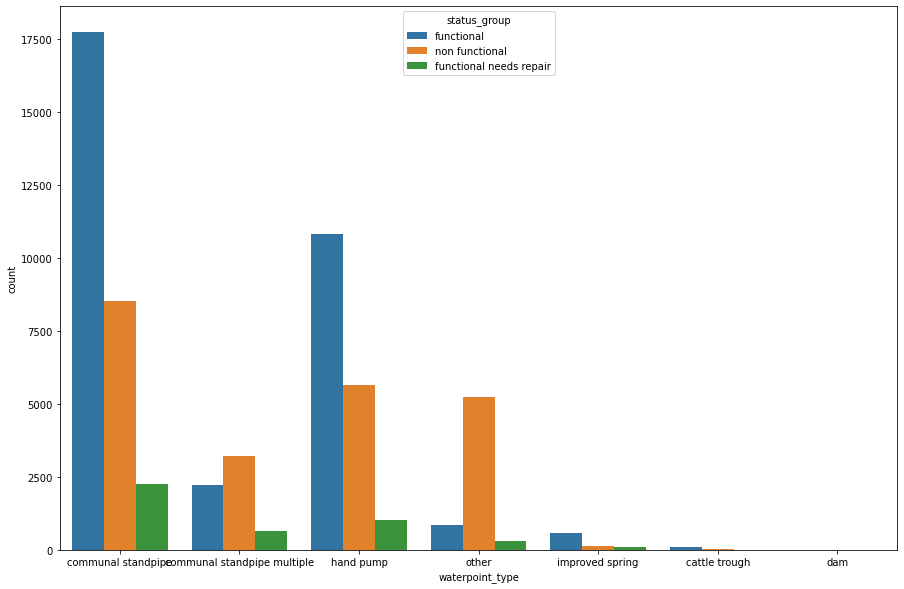

In [14]:
plt.figure(figsize=(15, 10))

sns.countplot(data=data,x='waterpoint_type',hue='status_group')

<AxesSubplot:xlabel='waterpoint_type', ylabel='count'>

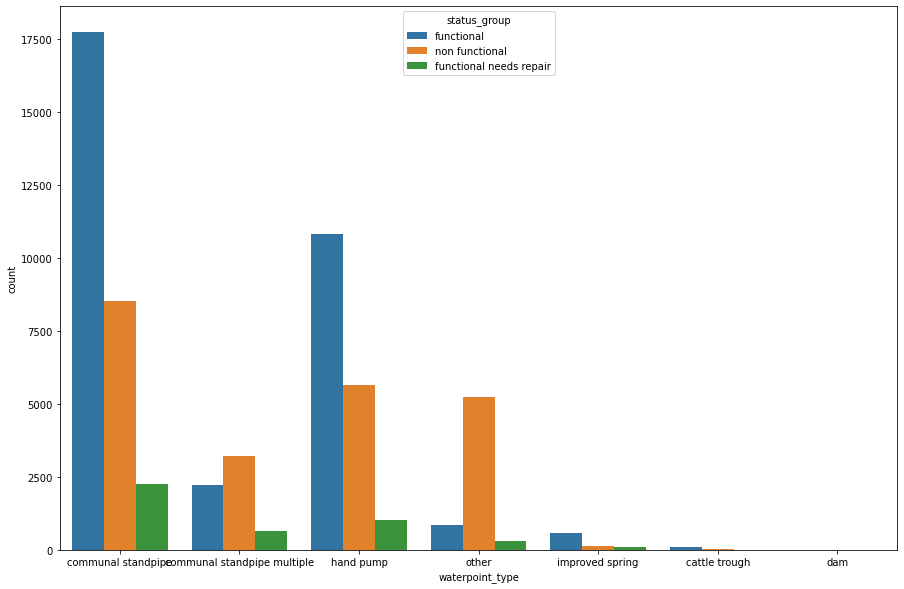

In [15]:
plt.figure(figsize=(15, 10))

sns.countplot(data=data,x='waterpoint_type',hue='status_group')

<AxesSubplot:xlabel='region', ylabel='count'>

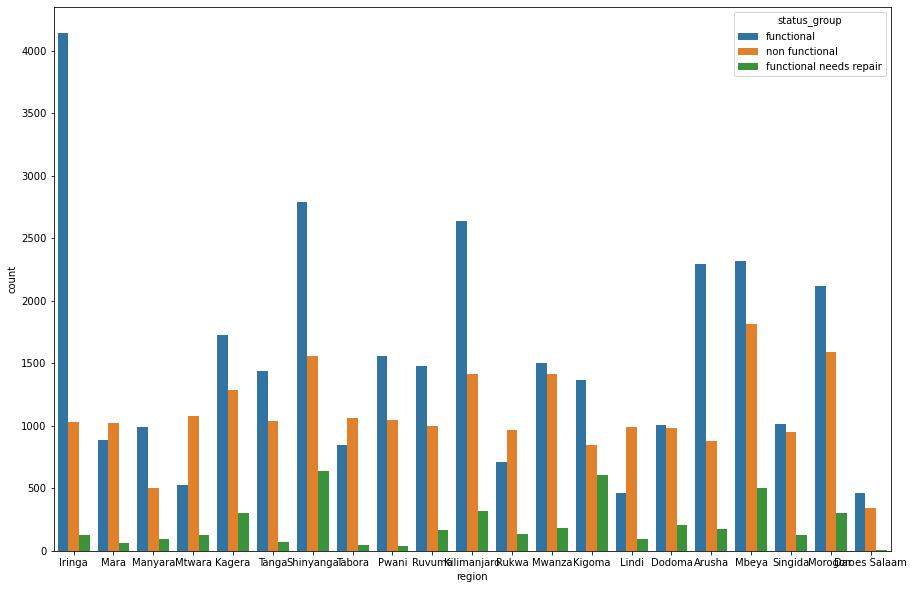

In [16]:
plt.figure(figsize=(15, 10))

sns.countplot(data=data,x='region',hue='status_group')

There is something interesting with longitude

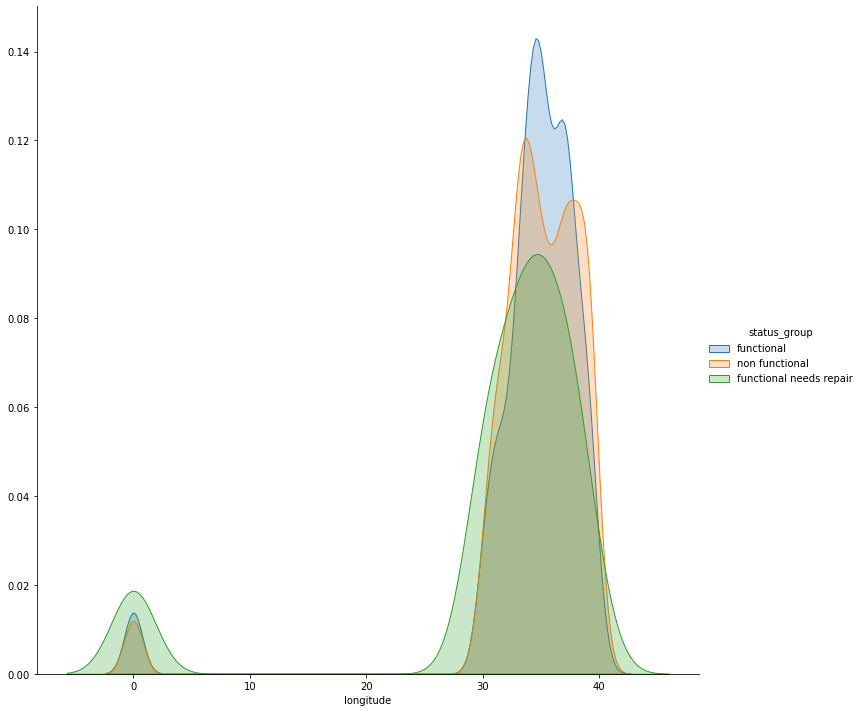

In [17]:
sns.FacetGrid(data, hue='status_group',height=10).map(sns.kdeplot, 'longitude', shade=True).add_legend()

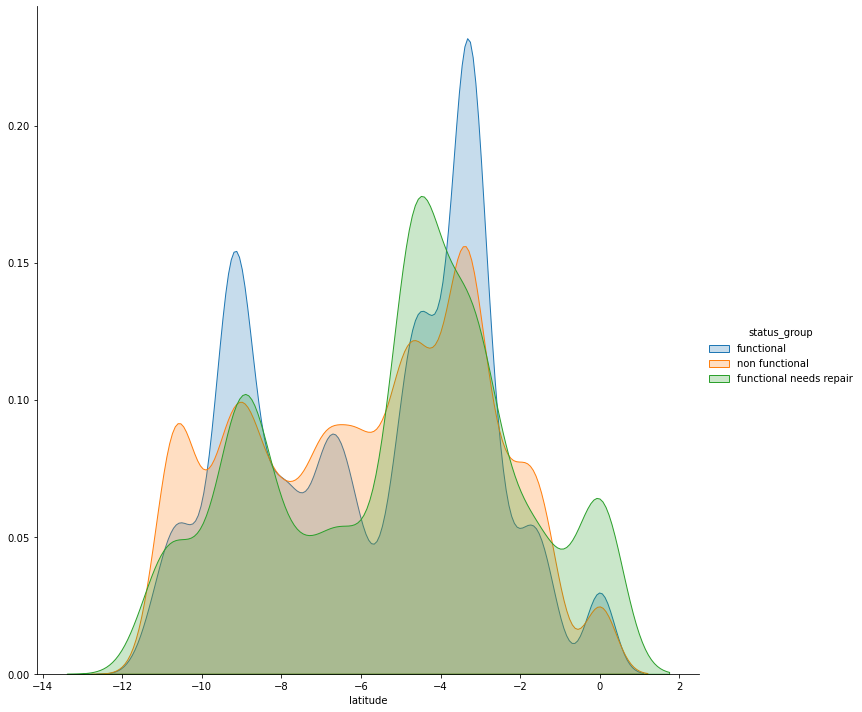

In [18]:
sns.FacetGrid(data, hue='status_group', height = 10).map(sns.kdeplot, 'latitude', shade = True).add_legend()

<AxesSubplot:xlabel='quantity', ylabel='count'>

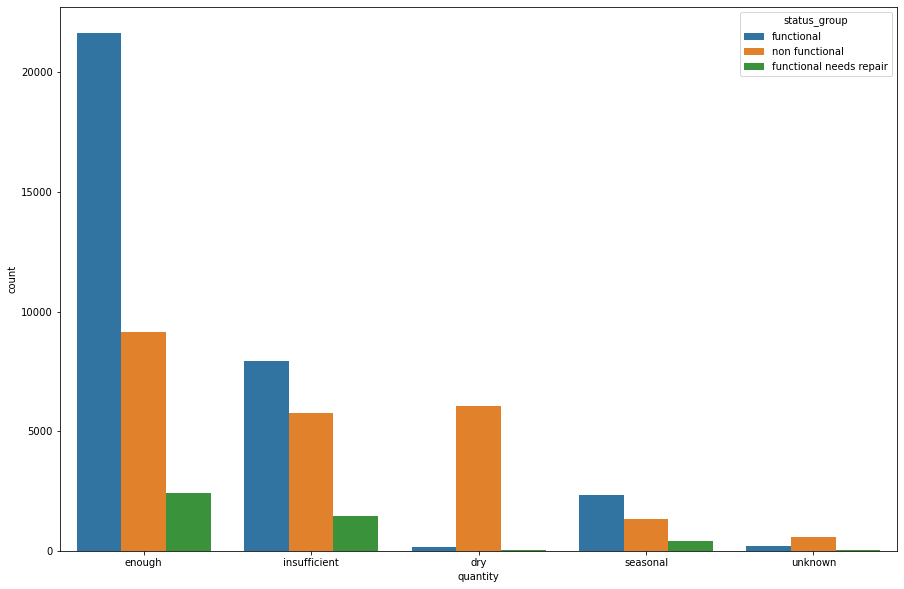

In [19]:
plt.figure(figsize=(15, 10))

sns.countplot(data=data,x='quantity',hue='status_group')

Now I get rid of a bunch of features. Id, recorded by, etc were removed because they would only serve to bias the models. Quality group, source type and most of the others were duplicates. A remaining few , like sheme name, were removed, becuase the data inputed was unclear or unhelpful.

In [20]:
waste_features=['wpt_name','num_private','subvillage','region_code','recorded_by','management_group',
                'extraction_type_group','extraction_type_class','scheme_name','payment','quality_group',
                'quantity_group','source_type','source_class','waterpoint_type_group','ward','installer',
                'public_meeting','permit','date_recorded','construction_year','id']
data.drop(waste_features, axis = 1, inplace = True)

Heres what the data looks like now.

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59400 entries, 0 to 59399
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   status_group       59400 non-null  object 
 1   amount_tsh         59400 non-null  float64
 2   funder             55765 non-null  object 
 3   gps_height         59400 non-null  int64  
 4   longitude          59400 non-null  float64
 5   latitude           59400 non-null  float64
 6   basin              59400 non-null  object 
 7   region             59400 non-null  object 
 8   district_code      59400 non-null  int64  
 9   lga                59400 non-null  object 
 10  population         59400 non-null  int64  
 11  scheme_management  55523 non-null  object 
 12  extraction_type    59400 non-null  object 
 13  management         59400 non-null  object 
 14  payment_type       59400 non-null  object 
 15  water_quality      59400 non-null  object 
 16  quantity           594

Lets deal with objects in the data set

In [22]:
data['funder'] = pd.factorize(data['funder'])[0]
data['scheme_management'] = pd.factorize(data['scheme_management'])[0]
data['extraction_type'] = pd.factorize(data['extraction_type'])[0]
data['management'] = pd.factorize(data['management'])[0]
data['payment_type'] = pd.factorize(data['payment_type'])[0]
data['water_quality'] = pd.factorize(data['water_quality'])[0]
data['quantity'] = pd.factorize(data['quantity'])[0]
data['source'] = pd.factorize(data['source'])[0]
data['waterpoint_type'] = pd.factorize(data['waterpoint_type'])[0]
data['basin'] = pd.factorize(data['basin'])[0]
data['region'] = pd.factorize(data['region'])[0]
data['lga'] = pd.factorize(data['lga'])[0]
data['district_code'] = pd.factorize(data['district_code'])[0]

Create an X and y, with y being our target

In [23]:
y = data.status_group
X = data.drop('status_group', axis = 1)

Split the data set so for training and testing

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

Scale the Data (Avoid leakage!)

In [25]:
sc = StandardScaler()
sc.fit(X_train)
X_scaled_train = sc.transform(X_train)
X_scaled_test = sc.transform(X_test)

Modeling

1st Model - Dummy Model\

This model is used as a baseline and is not very good.

In [26]:
# Instantiate Model
dummy_model = DummyClassifier(strategy='stratified')

# Fit Model
dummy_model.fit(X_scaled_train, y_train)

# Make Predictions
dummy_model_pred_train = dummy_model.predict(X_scaled_train)
dummy_model_pred_test = dummy_model.predict(X_scaled_test)

# Save Information
dummy_model_results = ModelWithCV(
                        model=dummy_model,
                        model_name='dummy',
                        X=X_scaled_train, 
                        y=y_train)

# Print Evaluation
PrintEvaluation(y_train, y_test, X_scaled_train, X_scaled_test, dummy_model_pred_train, dummy_model_pred_test, dummy_model)

## Feature importance
#print('Feature Importances')
#print(dummy_model.feature_importances_)
#plot_feature_importances(dummy_model)

Training Metrics
Model: DummyClassifier(strategy='stratified')
Accuracy: 0.4432996632996633
F1-Score: 0.3266226400766155
Precision: 0.3265996472960213
Recall: 0.3266874930717935

Training Cross Val Score
[0.45589226 0.453367   0.45521886 0.4459596  0.44882155]

Testing Metrics
Model: DummyClassifier(strategy='stratified')
Accuracy: 0.44427609427609427
F1-Score: 0.3328320854282432
Precision: 0.33292843303608444
Recall: 0.3327657141701374

Testing Cross Val Score
[0.44848485 0.4506734  0.43888889 0.44141414 0.44427609]


CV Results for `dummy` model:
            0.45178 ± 0.01254 accuracy
        


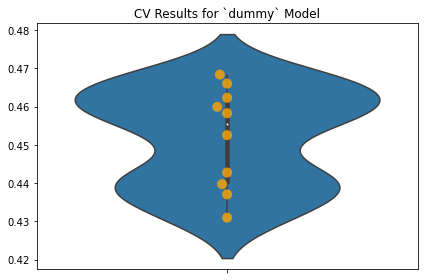

In [27]:
fig, ax = plt.subplots()

ax = dummy_model_results.plot_cv(ax)
plt.tight_layout();

dummy_model_results.print_cv_summary()

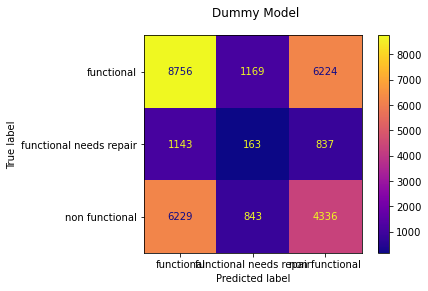

In [28]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

plot_confusion_matrix(dummy_model, X_scaled_train, y_train, ax=ax, cmap="plasma");

2nd Model: Log Regression \
This model did not perform well. It had one of the lowest accuracy scores.

In [29]:
# Instantitate Model
simple_logreg_model = LogisticRegression(random_state=2021, penalty='none')

# Fit Model
simple_logreg_model.fit(X_scaled_train, y_train)

# Make Predictions
simple_logreg_pred_train = simple_logreg_model.predict(X_scaled_train)
simple_logreg_pred_test = simple_logreg_model.predict(X_scaled_test)

# Save Information
simple_logreg_results = ModelWithCV(
                        model=simple_logreg_model,
                        model_name='Simple Logreg',
                        X=X_scaled_train, 
                        y=y_train)

# Evaluate Model
PrintEvaluation(y_train, y_test, X_scaled_train, X_scaled_test, simple_logreg_pred_train,
                    simple_logreg_pred_test, simple_logreg_model)

Training Metrics
Model: LogisticRegression(penalty='none', random_state=2021)
Accuracy: 0.6374074074074074
F1-Score: 0.4249180534740104
Precision: 0.5040754899410311
Recall: 0.43848257377702243

Training Cross Val Score
[0.63552189 0.64107744 0.6459596  0.62912458 0.63282828]

Testing Metrics
Model: LogisticRegression(penalty='none', random_state=2021)
Accuracy: 0.6361616161616162
F1-Score: 0.425022001944924
Precision: 0.48450421113415487
Recall: 0.43885575724473497

Testing Cross Val Score
[0.63417508 0.62794613 0.63198653 0.64410774 0.63535354]


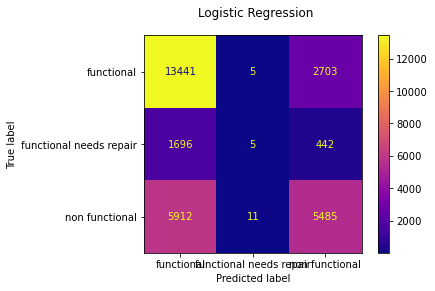

In [30]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression")

plot_confusion_matrix(simple_logreg_model, X_scaled_train, y_train, ax=ax, cmap="plasma");

3rd Model: K Nearnest Neighbors\
This model performs better but still not very good\
I also check for the ideal k, but the default was the best one so I didn't remake the model.

In [31]:
# Instantiate KNeighborsClassifier
KNC = KNeighborsClassifier()

# Fit the classifier
KNC.fit(X_scaled_train, y_train)

# Predict on the test set
KNC_prediction_train = KNC.predict(X_scaled_train)
KNC_prediction_test = KNC.predict(X_scaled_test)

# Save Information
KNeighborsClassifier_model_results = ModelWithCV(
                        model=KNC,
                        model_name='KNeighborsClassifier',
                        X=X_scaled_train, 
                        y=y_train)

# Evaluate Model
PrintEvaluation(y_train = y_train, y_test = y_test, X_train = X_scaled_train, X_test = X_scaled_test,
                train_preds = KNC_prediction_train, test_preds = KNC_prediction_test , model = KNC)


# Improve Model by Finding Best K
best_k = find_best_k(X_scaled_train, y_train, X_scaled_test, y_test)
print("best k", best_k)


Training Metrics
Model: KNeighborsClassifier()
Accuracy: 0.8222895622895623
F1-Score: 0.7273569326502273
Precision: 0.7791523230216577
Recall: 0.6988885574147901

Training Cross Val Score
[0.7479798  0.74225589 0.74814815 0.73670034 0.74191919]

Testing Metrics
Model: KNeighborsClassifier()
Accuracy: 0.7546464646464647
F1-Score: 0.6378469679002101
Precision: 0.671159428749858
Recall: 0.6196419031308693

Testing Cross Val Score
[0.75084175 0.74225589 0.74191919 0.75252525 0.74478114]
Best Value for k: 5
F1-Score: 0.7546464646464647
best k None


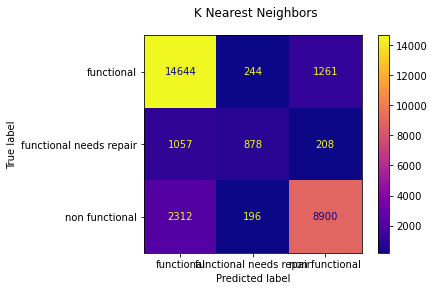

In [32]:
fig, ax = plt.subplots()

fig.suptitle("K Nearest Neighbors")

plot_confusion_matrix(KNC, X_scaled_train, y_train, ax=ax, cmap="plasma");

4th Model: Decision Tree Classifier\
The model was very overfit. I will use random forest to compensate for this.

In [33]:
# Instantiate Model
dtc = DecisionTreeClassifier(criterion='entropy')

# Fit Model
dtc.fit(X_train, y_train)

# Make Predictions
dtc_predictions_train = dtc.predict(X_train)
dtc_predictions_test = dtc.predict(X_test)

# Save Information
dtc_model_results = ModelWithCV(
                        model=dtc,
                        model_name='Decision Tree Classifier',
                        X=X_train, 
                        y=y_train)

# Evaluate Model
PrintEvaluation(y_train, y_test, X_train, X_test, dtc_predictions_train, dtc_predictions_test, dtc)

## Feature importance
print('Feature Importances')
print(dtc.feature_importances_)
plot_feature_importances(dtc, 'Feature Importance')

Training Metrics
Model: DecisionTreeClassifier(criterion='entropy')
Accuracy: 0.997037037037037
F1-Score: 0.9931803680070402
Precision: 0.9948372520216977
Recall: 0.9915452017401787

Training Cross Val Score
[0.7486532  0.73282828 0.73720539 0.74309764 0.73670034]

Testing Metrics
Model: DecisionTreeClassifier(criterion='entropy')
Accuracy: 0.7438383838383839
F1-Score: 0.6407312296630119
Precision: 0.6391556573117224
Recall: 0.6423867181700748

Testing Cross Val Score
[0.74006734 0.73989899 0.73501684 0.73383838 0.73131313]
Feature Importances
[0.02614497 0.06689317 0.08205963 0.20279021 0.18138096 0.00924822
 0.01072777 0.01870302 0.03076622 0.05688579 0.01388031 0.03514032
 0.01607996 0.0209183  0.0114181  0.12998941 0.03056732 0.05640632]


TypeError: plot_feature_importances() takes 1 positional argument but 2 were given

In [ ]:
fig, ax = plt.subplots()

fig.suptitle("Decision Tree")

plot_confusion_matrix(dtc, X_train, y_train, ax=ax, cmap="plasma");

Plot the decision tree

In [ ]:
fig, axes = plt.subplots(nrows = 1,ncols = 1, figsize = (3,3), dpi=300)
tree.plot_tree(dtc,
               feature_names = data.columns, 
               class_names=np.unique(y).astype('str'),
               filled = True)
plt.show()

5th Model: Bagged Trees\
This model performs well as it mitigates some of the negative tendencies of Decision Trees.

In [ ]:
# Instantiate a BaggingClassifier
bagged_tree =  BaggingClassifier(DecisionTreeClassifier(criterion='gini', max_depth=5), 
                                 n_estimators=100, random_state = 42)

# Fit to the training data
bagged_tree.fit(X_train, y_train)

# Make Predictions
bagged_tree_predictions_train = bagged_tree.predict(X_train)
bagged_tree_predictions_test = bagged_tree.predict(X_test)

# Save Information
bagged_tree_model_results = ModelWithCV(
                        model=bagged_tree,
                        model_name='bagged tree',
                        X=X_train, 
                        y=y_train)

# Evaluate Model
PrintEvaluation(y_train, y_test, X_train, X_test,
                bagged_tree_predictions_train, bagged_tree_predictions_test, bagged_tree)

In [ ]:
fig, ax = plt.subplots()

fig.suptitle("Bagged Trees")

plot_confusion_matrix(bagged_tree, X_train, y_train, ax=ax, cmap="plasma");

6th Model: Random forests\
This is by far the best model. Although it is still prone to overfitting.

In [ ]:
# Instanitate Model
rfc = RandomForestClassifier(n_estimators=500,max_features='sqrt',
                                         min_samples_split=8)

# Fit Model
rfc.fit(X_train, y_train)

# Predict with Model
rfc_prediction_train = rfc.predict(X_train)
rfc_prediction_test = rfc.predict(X_test)

# Save Information
rfc_model_results = ModelWithCV(
                        model=rfc,
                        model_name='Random Forest Classifier',
                        X=X_train, 
                        y=y_train)

# Evaluate Model
PrintEvaluation(y_train, y_test, X_train, X_test, rfc_prediction_train, rfc_prediction_test, rfc)

# Estimators
#estimators = rfc.estimators_

## Feature importance
print('Feature Importances')
print(rfc.feature_importances_)
plot_feature_importances(rfc, title = '')

In [ ]:
fig, ax = plt.subplots()

fig.suptitle("Random Forest")

plot_confusion_matrix(rfc, X_train, y_train, ax=ax, cmap="plasma");

Weak Learners

8th Model: GradientBoostingClassifier\
This model does not improve upon the performance of the random forest model.

In [ ]:
# Instantiate an GradientBoostingClassifier
gbt_clf = GradientBoostingClassifier(random_state=42)

# Fit the models
gbt_clf.fit(X_train, y_train)

# GradientBoosting model predictions
gbt_clf_train_preds = gbt_clf.predict(X_train)
gbt_clf_test_preds = gbt_clf.predict(X_test)

# Save Information
GradientBoostingClassifier_model_results = ModelWithCV(
                        model=gbt_clf,
                        model_name='GradientBoostingClassifier',
                        X=X_train, 
                        y=y_train)

# Evaluate Model
PrintEvaluation(y_train, y_test, X_train, X_test,
                gbt_clf_train_preds, gbt_clf_test_preds , gbt_clf)


## Feature importance
print('Feature Importances')
print(gbt_clf.feature_importances_)
plot_feature_importances(gbt_clf)


#gbt_confusion_matrix = confusion_matrix(y_test, gbt_clf_test_preds)
#gbt_confusion_matrix
#gbt_classification_report = classification_report(y_test, gbt_clf_test_preds)
#print(gbt_classification_report)

Stacking Models\
No ensemble combination improved accuracy score.

In [ ]:
# Instantiate Stacking Regressor and Make Estimators
estimators = [
    ('dtr', DecisionTreeClassifier()),
    ('rfc', RandomForestClassifier()),
    ('bagged_tree', BaggingClassifier())]

vc = VotingClassifier(estimators)

# Fit the Regressor
vc.fit(X_scaled_train, y_train)

# Model Predictions
vc_train_preds = vc.predict(X_scaled_train)
vc_test_preds = vc.predict(X_scaled_test)

# Evaluate Model
PrintEvaluation(y_train, y_test, X_scaled_train, X_scaled_test,
                vc_train_preds, vc_test_preds , vc)

Models Compared

Conclusion

In [ ]:
Baseline_Model = [0.44562289562289564, 0.3316720558783817, 0.331706937508360, 0.33165428054555934]
Random_ForestClassifier = [0.8001010101010101, 0.6806146618207686, 0.7370616409446141, 0.6550893922974595]
n=4
r = np.arange(n)
width = 0.25
  
  
plt.bar(r, Baseline_Model, color = 'b',
        width = width, edgecolor = 'black',
        label='Baseline Model')
plt.bar(r + width, Random_ForestClassifier, color = 'g',
        width = width, edgecolor = 'black',
        label='Final Model')
  
plt.xlabel("Model Evaluators")
plt.ylabel("Score")
plt.title("Success of Models")
  
# plt.grid(linestyle='--')
plt.xticks(r + width/2,['Accuracy','F1','Precision','Recall'])
plt.legend()
  
plt.show()

Our model can be used to predict the functionality of wells. This will become increasingly valueable as climate change increase water insecuty.  Our model performs well with an accuracy rate of 80%. I selected accuracy as the relavent metric because well condition will be confirmed with human inspection before resource investment, as such errors are not overly costly. This model had the best accuracy score on the test data. By predicting which wells will be functional, Wells of Life will be able to more effiently plan and distribute resources to address the problem of water insecurity.
